In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
# data_path = Path('/../train/')

In [2]:
# train_folder = '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/flair/FLAIR-1-AI-Challenge/flair_aerial_train'
# mask_folder = '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/flair/FLAIR-1-AI-Challenge/flair_labels_train'

# def get_data_paths (path, filter):
#     for path in Path(path).rglob(filter):
#          yield path.resolve().as_posix()

# images = sorted(list(get_data_paths(Path(train_folder), 'IMG*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
# masks  = sorted(list(get_data_paths(Path(mask_folder), 'MSK*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))

In [3]:
train_folder = '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/flair/FLAIR-1-AI-Challenge/imgs'
mask_folder = '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/flair/FLAIR-1-AI-Challenge/msks'

def get_data_paths (path, filter):
    for path in Path(path).rglob(filter):
         yield path.resolve().as_posix()

images = sorted(list(get_data_paths(Path(train_folder), '*.npy')))
masks  = sorted(list(get_data_paths(Path(mask_folder), '*.npy')))

In [4]:
from sklearn.preprocessing import StandardScaler

def Normalise(arr_band):
    
    return StandardScaler().fit_transform(arr_band)

In [5]:
# import rasterio

# def read_img(raster_file: str) -> np.ndarray:
#     with rasterio.open(raster_file) as src:
#         arr_1, arr_2, arr_3, arr_4, arr_5 = Normalise(src.read(1)), Normalise(src.read(2)), Normalise(src.read(3)), Normalise(src.read(4)), Normalise(src.read(5))
#         return sum((arr_1, arr_2, arr_3, arr_4, arr_5))

# def read_msk(raster_file: str) -> np.ndarray:
#     with rasterio.open(raster_file) as src_msk:
#         array = src_msk.read()[0]
#         array[array > 13] = 13
#         array = array-1
#         array = np.stack([array == i for i in range(13)], axis=0)
#         return array
    
# for i in range(len(images)):
#     img = read_img(images[i]).astype(np.float32)
#     # msk = read_msk(masks[i])
#     # save the formatted images
#     np.save(f'/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/flair/FLAIR-1-AI-Challenge/imgs/img_{i}.npy', img)
#     # np.save(f'/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/flair/FLAIR-1-AI-Challenge/msks/msk_{i}.npy', msk)

In [6]:
# config
# resnet34, efficientnet-b1, resnext101_32x8d_wsl, resnext101_32x16d_wsl
config = {
    "data_path": "../",
    "model": {
        "encoder_name": "timm-resnest26d",
        "loss_smooth": 1.0,
        "optimizer_params": {"lr": 0.003, "weight_decay": 0.0},
        "scheduler": {
            "name": "CosineAnnealingLR",
            "params": {
                "CosineAnnealingLR": {"T_max": 500, "eta_min": 1e-06, "last_epoch": -1},
                "ReduceLROnPlateau": {
                    "factor": 0.3162,
                    "mode": "min",
                    "patience": 4,
                    "verbose": True,
                },
            },
        },
        "seg_model": "Unet",
    },
    "output_dir": "models",
    "progress_bar_refresh_rate": 10,
    "seed": 42,
    "train_bs":15,
    "trainer": {
        "enable_progress_bar": True,
        "max_epochs": 30,
        "min_epochs": 20,
        "accelerator": "mps",
        "devices": 1,
    },
    "valid_bs": 15,
    "workers": 0,
    "device": "mps",
    "folds": {
        "n_splits": 4,
        "random_state": 42,
        "train_folds": [0, 1, 2, 3]
    }
}


In [7]:
import torchvision.transforms as T
import torch
import numpy as np
import rasterio
from skimage import img_as_float

class FlairDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, image_size=256, num_classes=13):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        self.image_size = image_size
        self.num_classes = num_classes
        # if image_size != 256:
        #     self.resize_image = T.Resize((image_size, image_size))
        #     self.resize_mask = T.Resize((image_size, image_size), interpolation=Image.NEAREST)
            

    def read_img(self, raster_file: str) -> np.ndarray:
        with rasterio.open(raster_file) as src:
            arr_1, arr_2, arr_3, arr_4, arr_5 = Normalise(src.read(1)), Normalise(src.read(2)), Normalise(src.read(3)), Normalise(src.read(4)), Normalise(src.read(5))
            return sum((arr_1, arr_2, arr_3, arr_4, arr_5))

    def read_msk(self, raster_file: str) -> np.ndarray:
        with rasterio.open(raster_file) as src_msk:
            array = src_msk.read()[0]
            array[array > self.num_classes] = self.num_classes
            array = array-1
            array = np.stack([array == i for i in range(self.num_classes)], axis=0)
            return array
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        img = np.load(image_path)
        msk = np.load(mask_path)         
        
        # img = img_as_float(img)

        # # Resize if necessary
        # if self.image_size != 256:
        #     img = self.resize_image(img)
        #     label = self.resize_mask(label)

        # Transform the image and mask to tensors
        img = torch.as_tensor(img, dtype=torch.float).unsqueeze(0)
        msk = torch.as_tensor(msk, dtype=torch.float)

        # Normalize the image
        # img = self.normalize_image(img)

        return img, msk

    def __len__(self):
        return len(self.image_paths)


In [8]:
# import torch
# import numpy as np
# import torchvision.transforms as T

# class ContrailsDataset(torch.utils.data.Dataset):
#     def __init__(self, df, image_size=256, train=True):

#         self.df = df
#         self.trn = train
#         self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#         self.image_size = image_size
#         if image_size != 256:
#             self.resize_image = T.transforms.Resize(image_size)

#     def __getitem__(self, index):
#         row = self.df.iloc[index]
#         con_path = row.path
#         con = np.load(str(con_path))

#         img = con[..., :-1]
#         label = con[..., -1]

#         label = torch.tensor(label)

#         img = torch.tensor(np.reshape(img, (256, 256, 3))).to(torch.float32).permute(2, 0, 1)

#         if self.image_size != 256:
#             img = self.resize_image(img)

#         img = self.normalize_image(img)

#         return img.float(), label.float()

#     def __len__(self):
#         return len(self.df)

In [9]:
import torch
import lightning.pytorch as pl
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import AdamW
import torch.nn as nn
from lightning.pytorch.callbacks import ProgressBar
from torchmetrics.functional import dice, f1_score, jaccard_index
import gc

bar = ProgressBar()

seg_models = {
    "Unet": smp.Unet,
    "Unet++": smp.UnetPlusPlus,
    "MAnet": smp.MAnet,
    "Linknet": smp.Linknet,
    "FPN": smp.FPN,
    "PSPNet": smp.PSPNet,
    "PAN": smp.PAN,
    "DeepLabV3": smp.DeepLabV3,
    "DeepLabV3+": smp.DeepLabV3Plus,
}

# class DiceLoss(nn.Module):
#     def __init__(self, smooth=1):
#         super(DiceLoss, self).__init__()
#         self.smooth = smooth

#     def forward(self, logits, targets):
#         logits = torch.sigmoid(logits)

#         batch_size, num_classes, height, width = logits.size()

#         logits = logits.reshape(batch_size, -1)
#         targets = targets.reshape(batch_size, -1)

#         intersection = (logits * targets).sum(dim=1)
#         union = logits.sum(dim=1) + targets.sum(dim=1)
#         dice_coeff = (2.0 * intersection + self.smooth) / (union + self.smooth)

#         return 1 - dice_coeff.mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        logits = torch.sigmoid(logits)

        # flatten label and prediction tensors
        logits = logits.view(-1)
        targets = targets.view(-1)

        intersection = (logits * targets).sum()
        return 1 - (2.0 * intersection + self.smooth) / (
            logits.sum() + targets.sum() + self.smooth
        )


class LightningModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = seg_models[config["seg_model"]](
            encoder_name=config["encoder_name"],
            encoder_weights="imagenet",
            in_channels=1,
            classes=13,
            activation=None,
        )
        self.loss_module = DiceLoss(smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, batch):
        imgs = batch.to(self.device)
        return self.model(imgs)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        # labels = labels.unsqueeze(1)
        # labels = labels.expand(-1, 13, -1, -1)
        preds = self.model(imgs)
        del imgs
        loss = self.loss_module(preds, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=16)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        # labels = labels.unsqueeze(1)
        # labels = labels.expand(-1, 13, -1, -1)
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss , on_step=False, on_epoch=True, prog_bar=True)
        # self.val_step_outputs.append(preds)
        # self.val_step_labels.append(labels)

    # def on_validation_epoch_end(self):
    #     all_preds = torch.cat(self.val_step_outputs)
    #     all_labels = torch.cat(self.val_step_labels)
    #     self.val_step_outputs.clear()
    #     self.val_step_labels.clear()
    #     val_iou = jaccard_index(num_classes=13, preds=all_preds.sigmoid(), target=all_labels.long(), task='multiclass')
    #     self.log("val_iou", val_iou, on_step=False, on_epoch=True, prog_bar=True)


In [10]:
import warnings

warnings.filterwarnings("ignore")

import os
import torch
import pandas as pd
import lightning.pytorch as pl
from pprint import pprint
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from torch.utils.data import DataLoader


# Split your data into train and validation sets, here I simply split it 80-20

fraction = 1

split_point = int(len(images) * 0.8 * fraction)
train_split = int(len(images) * 0.8 * 0.8 * fraction)

train_image_paths = images[:split_point]
train_mask_paths = masks[:split_point]

valid_image_paths = images[split_point:]
valid_mask_paths = masks[split_point:]

# Use your dataset class
dataset_train = FlairDataset(train_image_paths, train_mask_paths)
dataset_validation = FlairDataset(valid_image_paths, valid_mask_paths)

data_loader_train = DataLoader(
    dataset_train, batch_size=config["train_bs"], shuffle=False, num_workers=config["workers"]
)
data_loader_validation = DataLoader(
    dataset_validation, batch_size=config["valid_bs"], shuffle=False, num_workers=config["workers"]
)

pl.seed_everything(config["seed"])

filename = f"{config['model']['seg_model']}_{config['model']['encoder_name']}"

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=config["output_dir"],
    mode="min",
    filename=filename,
    save_top_k=1,
    verbose=1,
)

progress_bar_callback = TQDMProgressBar(refresh_rate=config["progress_bar_refresh_rate"])

early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)

trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback], logger=None, **config["trainer"]
)

model = LightningModule(config["model"])

trainer.fit(model, data_loader_train, data_loader_validation)

Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type     | Params
-----------------------------------------
0 | model       | Unet     | 24.0 M
1 | loss_module | DiceLoss | 0     
-----------------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
96.139    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.679
Epoch 0, global step 3292: 'val_loss' reached 0.67940 (best 0.67940), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/Unet_timm-resnest26d-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.671
Epoch 1, global step 6584: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.629
Epoch 2, global step 9876: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.602
Epoch 3, global step 13168: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 16460: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.597
Epoch 5, global step 19752: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.572
Epoch 6, global step 23044: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 26336: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 29628: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 32920: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 36212: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.572. Signaling Trainer to stop.
Epoch 11, global step 39504: 'val_loss' was not in top 1
Trainer was signaled to stop but the required `min_epochs=20` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.572. Signaling Trainer to stop.
Epoch 12, global step 42796: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.568
Epoch 13, global step 46088: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 49380: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.551
Epoch 15, global step 52672: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 55964: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.524
Epoch 17, global step 59256: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 62548: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.518
Epoch 19, global step 65840: 'val_loss' was not in top 1


In [14]:
# save the current model checkpoint
trainer.save_checkpoint(os.path.join(config["output_dir"], f"{filename}.ckpt"))

In [11]:
%reload_ext tensorboard

In [13]:
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 30473), started 0:00:05 ago. (Use '!kill 30473' to kill it.)

In [15]:
# save the model
torch.save(model.state_dict(), f'models/{filename}.pt')

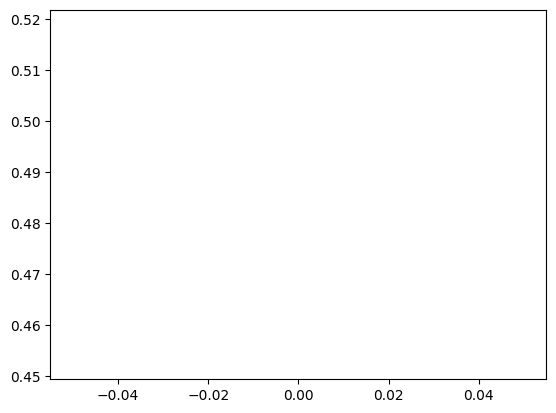

In [16]:
# plot the training and validation loss
plt.plot(trainer.callback_metrics['train_loss'])
plt.plot(trainer.callback_metrics['val_loss'])